In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation
import math, random
torch.__version__

'1.10.0+cu111'

# 通过Sin预测Cos
在介绍循环神经网络时候我们说过，循环神经网络由于其的特殊结构，十分十分擅长处理`时间相关`的数据，下面我们就来通过输入sin函数，输出cos函数来实际使用。
首先，我们还是定义一些超参数。

In [2]:
TIME_STEP = 10 # rnn 时序步长数
INPUT_SIZE = 1 # rnn 的输入维度
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
H_SIZE = 64 # of rnn 隐藏单元个数
EPOCHS=300 # 总共训练次数
h_state = None # 隐藏层状态

由于使用sin和cos函数，所以这里不需要dataloader，我们直接使用Numpy生成数据Pytorch没有π这个常量，所以所有操作都是用Numpy完成

In [3]:
steps = np.linspace(0, np.pi*2, 256, dtype=np.float32)
x_np = np.sin(steps) 
y_np = np.cos(steps)

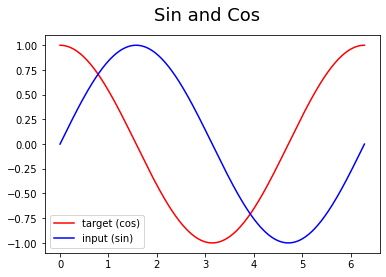

In [4]:
## 可视化数据
plt.figure(1)
plt.suptitle('Sin and Cos',fontsize='18')
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

In [5]:
## 定义RNN网络结构
class RNN(nn.Module):
  def __init__(self):
    super(RNN,self).__init__()
    self.rnn=nn.RNN(
        ## 这里直接用了Pytorch里面定义好的RNN
        input_size=INPUT_SIZE, ## 输入x的维度
        hidden_size=H_SIZE,  ## 隐藏单元的个数
        num_layers=1,  ## 几层RNN
        batch_first=True,
    )
    self.out=nn.Linear(H_SIZE,1) ## 两个输出：output，一个time-series中最后一层的所有隐藏状态，h_n跑完整个time-series的最后一个隐藏状态值
  def forward(self,x,h_state):
    # x (batch, time_step, input_size)
    # h_state (n_layers, batch, hidden_size)
    # r_out (batch, time_step, hidden_size) 上面的那个输出output
    r_out, h_state = self.rnn(x, h_state)
    outs = [] # 保存所有的预测值
    for time_step in range(r_out.size(1)): # 计算每一步长的预测值
      outs.append(self.out(r_out[:, time_step, :]))
      return torch.stack(outs, dim=1), h_state
      # 也可使用以下这样的返回值
      # r_out = r_out.view(-1, 32)
      # outs = self.out(r_out)
      # return outs, h_state

reference:
[Pytorch实现RNN](https://zhuanlan.zhihu.com/p/71732459)

In [6]:
## 定义网络
rnn = RNN().to(DEVICE)
optimizer = torch.optim.Adam(rnn.parameters()) # Adam优化，几乎不用调参
criterion = nn.MSELoss() # 因为最终的结果是一个数值，所以损失函数用均方误差

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 10, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


EPOCHS: 19,Loss:0.550000


ValueError: ignored

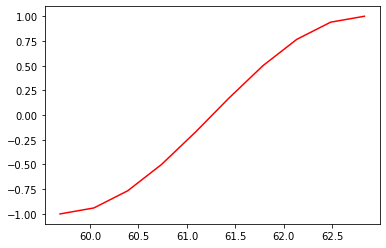

In [7]:
rnn.train()
plt.figure(2)
for step in range(EPOCHS):
    start, end = step * np.pi, (step+1)*np.pi # 一个时间周期
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps) 
    y_np = np.cos(steps)
    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis]) # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])
    x=x.to(DEVICE)
    prediction, h_state = rnn(x, h_state) # rnn output
    # 这一步非常重要
    h_state = h_state.data # 重置隐藏层的状态, 切断和前一次迭代的链接
    loss = criterion(prediction.cpu(), y) 
    # 这三行写在一起就可以
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if (step+1)%20==0: #每训练20个批次可视化一下效果，并打印一下loss
        print("EPOCHS: {},Loss:{:4f}".format(step,loss))
        plt.plot(steps, y_np.flatten(), 'r-')
        plt.plot(steps, prediction.cpu().data.numpy().flatten(), 'b-')
        plt.draw()
        plt.pause(0.01)


In [12]:
prediction.cpu().data.numpy().flatten()

array([-1.        , -0.9396928 , -0.7660436 , -0.5000006 , -0.17364706,
        0.17364734,  0.5000009 ,  0.7660438 ,  0.9396929 ,  1.        ],
      dtype=float32)